In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import random

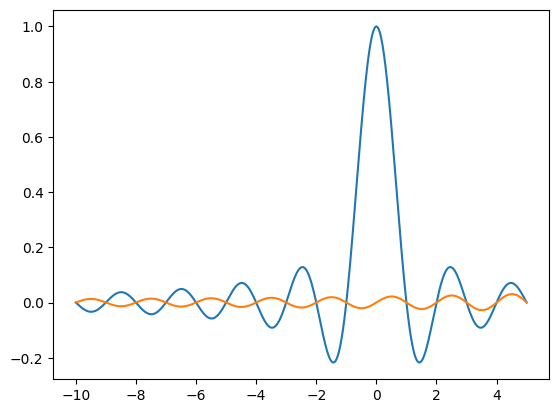

In [127]:
# plot a sinc function
x = np.linspace(-10,5,1000)
y = np.sinc(x)
y1 = np.sinc(15-x)
plt.plot(x,y)
plt.plot(x,y1)
plt.show()


In [128]:
class random_sinc:
    """
    Class representing a random sinc function.

    Attributes:

            t (float): Time parameter.
            random_lobes (float): Number of lobes of the sinc function.
            random_phase (float): Phase of the sinc function.
            r_zero (float): Right zero of the sinc function.
            l_zero (float): Left zero of the sinc function.
        """
    def __init__(self):
        self.random_lobes = np.random.uniform(1, 4)
        # first annulations of the sincs
        self.r_zero =  self.random_lobes
        self.l_zero =  - self.random_lobes

        self.random_flip = np.random.choice([1, -1])
        self.impulse_time = self.random_lobes - 2*self.l_zero + self.r_zero
        self.acquisition_time = 4*4


    def __call__(self, t):
        r_zero = self.r_zero
        l_zero = self.l_zero
        lobes = self.random_lobes
        null_time = self.acquisition_time-self.impulse_time

        flip = self.random_flip

        def plat_sinc(t):
            if t<0:
                return 0

            if t<(r_zero-l_zero)/2:
                return flip*np.sinc((t +l_zero)/lobes)

            if t>(r_zero-l_zero)/2 and t<(r_zero-l_zero)/2 + null_time/2:
                return flip

            if t>(r_zero-l_zero)/2+null_time/2 and t < (r_zero-l_zero)+null_time/2:
                return flip*np.sinc((t +l_zero - null_time/2)/lobes)

            if t >= (r_zero-l_zero)+null_time/2:
                return 0

        return plat_sinc(t)-plat_sinc(self.acquisition_time-t)


class random_linear:
    """
    Class representing a random linear function.

    Attributes:

        t (float): Time parameter.
        random_slope (float): Slope of the linear function.
        random_offset (float): Offset of the linear function.
    """

    def __init__(self):
        self.random_slope = np.random.uniform(-1, 1)
        self.acquisition_time = 1

    def __call__(self, t):
        return self.random_slope * t


class random_sin:
    """
    Class representing a random sin function.

    Attributes:

        t (float): Time parameter.
        random_amplitude (float): Amplitude of the sin function.
        random_frequency (float): Frequency of the sin function.
        random_phase (float): Phase of the sin function.
        random_offset (float): Offset of the sin function.
    """

    def __init__(self):
        self.random_amplitude = np.random.uniform(0, 1)
        self.random_frequency = np.random.uniform(0, 1)
        self.random_phase = np.random.uniform(0, np.pi)
        self.random_offset = np.random.normal()

    def __call__(self, t):
        return self.random_amplitude * np.sin(2 * np.pi * self.random_frequency * t)


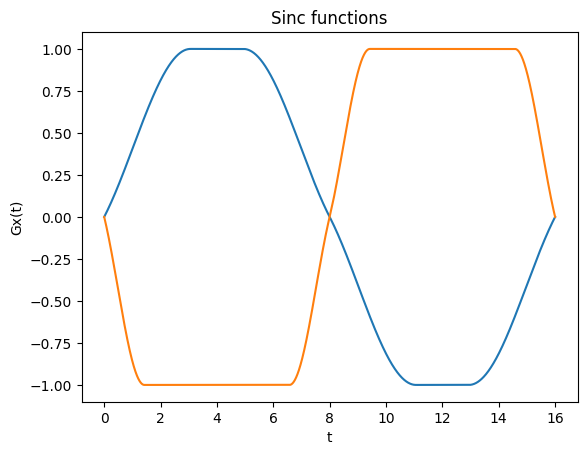

In [130]:
# plot the sincs

f1 = random_sinc()
f2 = random_sinc()
acquisition_time = f1.acquisition_time

t = np.linspace(0, acquisition_time, 10000)
y1 = [f1(t) for t in t]
y2 = [f2(t) for t in t]

plt.plot(t, y1, label="Sinc 1")
plt.plot(t, y2, label="Sinc 2")
plt.title("Sinc functions")
plt.xlabel("t")
plt.ylabel("Gx(t)")
plt.show()


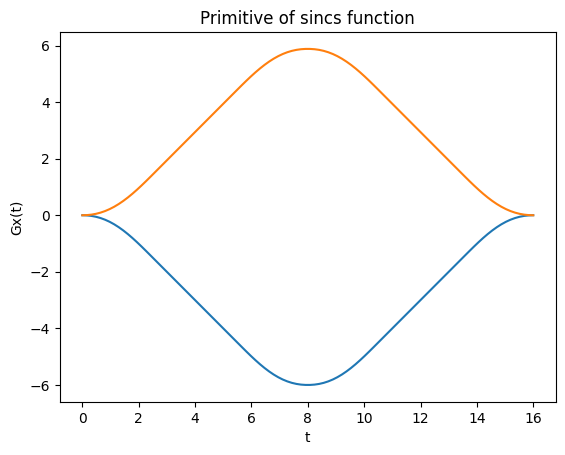

In [132]:
# plot the primitive of the sincs

f1 = random_sinc()
f2 = random_sinc()
t = np.linspace(0, acquisition_time, 100)
y1 = [quad(f1, 0, t)[0] for t in t]
y2 = [quad(f2, 0, t)[0] for t in t]
plt.plot(t, y1, label="Sinc 1")
plt.plot(t, y2, label="Sinc 2")
plt.title("Primitive of sincs function")
plt.xlabel("t")
plt.ylabel("Gx(t)")
plt.show()


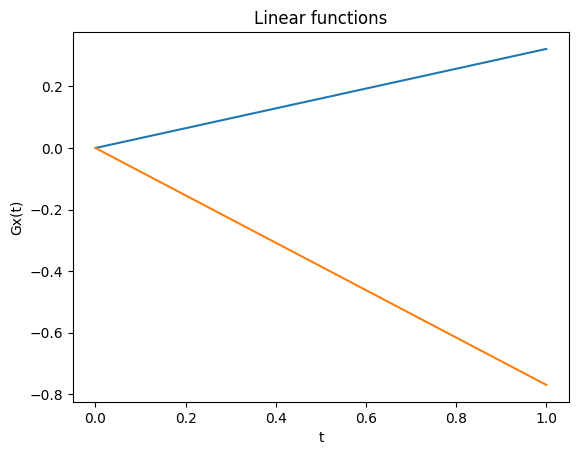

In [133]:
# plot the linear functions

f1 = random_linear()
f2 = random_linear()
t = np.linspace(0, 1, 100)

y1 = [f1(t) for t in t]
y2 = [f2(t) for t in t]
plt.plot(t, y1, label="Linear 1")
plt.plot(t, y2, label="Linear 2")
plt.title("Linear functions")
plt.xlabel("t")
plt.ylabel("Gx(t)")
plt.show()


/var/folders/q3/sl_3k64s2ldb0zk8pjw9qplc0000gn/T/ipykernel_49072/1617440845.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ky = quad(By, 0, times[i])[0]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


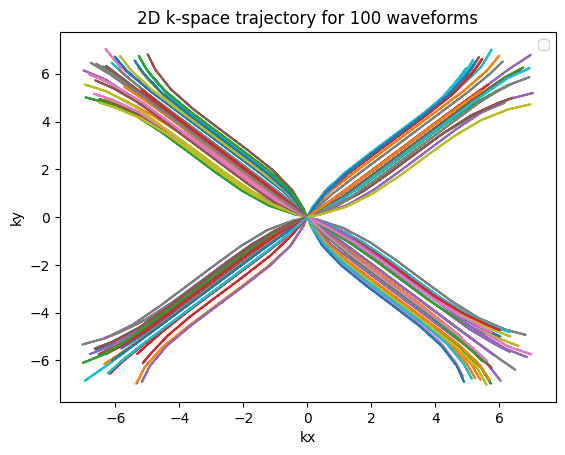

In [139]:
def kspace_path_2D(encoding_gradients, nbr_points):
    """
    Generate k-space trajectories from the encoding gradients for a 2D imaging sequence.

    Parameters:
        encoding_gradients (list): List of functions representing encoding gradients (Gx(t), Gy(t)).
        nbr_points (int): Number of points to sample along each dimension.

    Returns:
        None
    """

    # Extract Gx and Gy from the encoding_gradients list
    Bx = encoding_gradients[0]
    By = encoding_gradients[1]

    # Initialize an empty list to store k-space coordinates
    sampled_kspace = []

    # Generate time points for integration

    acquisition_time = Bx.acquisition_time

    times = np.linspace(0, acquisition_time, nbr_points)


    # Iterate over time points to compute k-space trajectories
    kx = 0
    ky = 0
    sampled_kspace.append([kx, ky])
    for i in range(nbr_points-1):
        # Integrate Gx and Gy over time to obtain kx and ky
        kx = quad(Bx, 0, times[i])[0]
        ky = quad(By, 0, times[i])[0]
        sampled_kspace.append([kx, ky])

    sampled_kspace = np.array(sampled_kspace)

    return sampled_kspace


def plot_kspace_trajectory(waveform, nbr_points_per_wave, nbr_waveforms):

    """
    Plot the k-space trajectory with different colors for each waveform.

    Parameters:
        kspace (ndarray): Array of k-space coordinates.
        nbr_waveforms (int): Number of waveforms used to generate k-space.

    Returns:
        None
    """

    # Generate k-space trajectories for each waveform
    for i in range(nbr_waveforms):
        # Generate encoding gradients for each waveform
        if waveform == 'linear':
            Bx = random_linear()
            By = random_linear()
            encoding_gradients = [Bx, By]

        if waveform == 'sinc':
            Bx = random_sinc()
            By = random_sinc()
            encoding_gradients = [Bx, By]

        if waveform == 'sin':
            Bx = random_sin()
            By = random_sin()
            encoding_gradients = [Bx, By]

        kspace = kspace_path_2D(encoding_gradients, nbr_points_per_wave)
        # Plot the points
        plt.plot(kspace[:, 0], kspace[:, 1])

    # Add labels and legend
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.title('2D k-space trajectory for {} waveforms'.format(nbr_waveforms))
    plt.legend()
    plt.show()


# Example usage
plot_kspace_trajectory('sinc', 20, 100)


In [105]:
class concatenated_functions:
    def __init__(self, list_functions, time):
        self.list_functions = list_functions
        self.time = time
        self.time_points = len(time)
        self.time_points_per_function = int(self.time_points/len(list_functions))

    def __call__(self, t):
        time_point = np.where(self.time == t)[0]
        index = int(time_point/self.time_points_per_function)
        t1 = t-index*self.time_points_per_function
        return self.list_functions[index](t1)
